In [2]:
import healpy as hp
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt

root = "/media/doujzh/AliCPT_data/Zirui_beamsys/TOD/"

In [ ]:
"""
Note:
The shape of the deprojection map (Ali) and the template (Planck):
maps/A150.npy contains IQU maps with shape (3, npix)
maps/A150_der contains 6 derivative maps with each shape (npix,)
maps/P150_der the same

"""

In [216]:
with open(root+'params' ,'rb') as f:
    params = pickle.load(f)

p150 = np.array(params[150])
p95 = np.array(params[95])
print(p150.shape) # (No. of time truncks, No. of beam sys, No. of detector pair)
dg = p150[:,0,:]
print(dg.shape)
dx = p150[:,1,:] * 180. / np.pi # in deg
dy = p150[:,2,:] * 180. / np.pi # in deg
ds = p150[:,3,:] # in deg
dp = p150[:,4,:]
dc = p150[:,5,:]

# p_perdp = p150[:,:,40]
# print(np.std(p_perdp, axis=0)/np.mean(p_perdp, axis=0))

(106, 6, 1728)
(106, 1728)


In [303]:
fp_r = np.load(root+'/fp/r.npy')
fp_theta = np.load(root+'/fp/theta.npy')
fp_chi = np.load(root+'/fp/chi.npy')
print(fp_r.shape, fp_theta.shape, fp_chi.shape)
print(fp_theta[0:3], fp_chi[0:3])
_dblang = 2*(fp_theta+fp_chi)
print(_dblang)

(1728,) (1728,) (1728,)
[0.52359878 1.23732315 1.38067072] [-0.52359878 -1.23732315 -1.38067072]
[ 2.22044605e-16 -4.44089210e-16  4.44089210e-16 ...  8.37284208e+00
  8.37319230e+00  8.37354261e+00]


In [114]:
scandir = root + 'scan/'

class Scan:
    def __init__(self, path):
        self.dict_names = ['ces_st',
                           'ces_ed',
                           'ces_prev_elnod',
                           'ces_succ_elnod',
                           'elnod_st',
                           'elnod_ed',
                           'tod_fname',
                           'mnt_fname',
                           'file_length',
                           'file_cumst',
                           'ces_time_st',
                           'ces_time_ed',
                           'ces_az_st',
                           'ces_az_ed',
                           'ces_daz',
                           'ces_el',
                           'ces_type']
        self.scans = {}
        with open(path, 'rb') as f:
            for name in self.dict_names:
                self.scans[name] = pickle.load(f)

        self.nscansets = 0
        for day in self.scans['ces_st']:
            scanst = self.scans['ces_st'][day]
            self.nscansets = self.nscansets + len(scanst)
    def loadday(self, day):
        file_length = self.scans['file_length'][day]
        file_cumst = self.scans['file_cumst'][day]
        nfile = len(file_length)
        length = np.sum(file_length)
        scan_trace = np.zeros((3, length))
        for i in range(nfile):
            ist = file_cumst[i]
            ied = ist + file_length[i]
            scan_trace[:, ist:ied] = np.load(scandir + day + f'/BS{day}P{i:03}.npy')

        self.trace = scan_trace
        self.scanst = self.scans['ces_st'][day]
        self.scaned = self.scans['ces_ed'][day]

s = Scan(scandir+'scancfg_all.pkl')
nscansets = s.nscansets
daylist = list(s.scans['ces_st'].keys())
print(nscansets)
fitidx = np.arange(30, nscansets-30, 30)
print(len(fitidx))
print(fitidx)

3183
105
[  30   60   90  120  150  180  210  240  270  300  330  360  390  420
  450  480  510  540  570  600  630  660  690  720  750  780  810  840
  870  900  930  960  990 1020 1050 1080 1110 1140 1170 1200 1230 1260
 1290 1320 1350 1380 1410 1440 1470 1500 1530 1560 1590 1620 1650 1680
 1710 1740 1770 1800 1830 1860 1890 1920 1950 1980 2010 2040 2070 2100
 2130 2160 2190 2220 2250 2280 2310 2340 2370 2400 2430 2460 2490 2520
 2550 2580 2610 2640 2670 2700 2730 2760 2790 2820 2850 2880 2910 2940
 2970 3000 3030 3060 3090 3120 3150]


In [115]:
print(np.array(s.scans['ces_ed']['20221001']).shape) # 12 scansets that day
print(len(s.scans['file_length']['20221001']))
print(len(s.scans['file_cumst']['20221001']))
print(np.load(scandir + '20221001' + '/BS20221001P000.npy').shape)

(12, 22)
59
60
(3, 45000)


In [138]:
isim = 1
for nu in [95, 150]:
    dg0 = np.loadtxt(root+'beamsys/dg_%dG.txt'%(nu)).T[2][isim]
    ds0 = np.loadtxt(root+'beamsys/dsigma_%dG.txt'%(nu)).T[2][isim]
    dx0_fp = np.loadtxt(root+'beamsys/dx_%dG.txt'%(nu)).T[2][isim]
    dy0_fp = np.loadtxt(root+'beamsys/dy_%dG.txt'%(nu)).T[2][isim]
    de0_mod = np.loadtxt(root+'beamsys/de_conti_%dG.txt'%(nu)).T[2][isim]
    de0_ori = np.loadtxt(root+'beamsys/de_orient_%dG.txt'%(nu)).T[2][isim]
    
    # pointing difference
    dx0_lcl = np.cos(_dblang) * dx0_fp + np.sin(_dblang) * dy0_fp
    dy0_lcl = -np.sin(_dblang) * dx0_fp + np.cos(_dblang) * dy0_fp

    # dsigma to dfwhm

    # eccentricity (temporary solution of jjin)
    # Here, base on the defination of de_ori by jjin, de_ori represents
    # the angle between the major axis of the beam difference map, at
    # linear order the beam difference map can be treated as an indivi-
    # dual ecliptic beam map, and the favour orientation of UP detector.
    dp0 = de0_mod * np.cos(_dblang + 2.*de0_ori)
    dc0 = de0_mod * np.sin(_dblang + 2.*de0_ori)

    print("first sim & detector pair @ "+str(nu)+'G')
    print("dg dsigma[deg] dx[deg] dy[deg] dp dc")
    print(dg0, ds0, dx0_lcl, dy0_lcl, dp0, dc0)

first sim & detector pair @ 95G
dg dsigma[deg] dx[deg] dy[deg] dp dc
-0.0020236973 -0.00036700108 -0.016014023999999998 0.008709105400000004 0.00019051216954040588 -0.0014768231389470329
first sim & detector pair @ 150G
dg dsigma[deg] dx[deg] dy[deg] dp dc
-0.0074252771 -0.00029819732 -0.019057076 0.005972925000000004 0.00042504499714173427 -0.005060632500963272


In [139]:
rad2deg = 180. / np.pi
# print("first sim & detector pair 150G 95G", "\n", \
#     "dg", np.mean(p150[:,0,isim]), np.mean(p95[:,0,isim]), "\n", \
#     "dsigma", np.mean(p150[:,3,isim]), np.mean(p95[:,3,isim]), "\n",\
#     "dx[deg]", np.mean(p150[:,1,isim]) * rad2deg, np.mean(p95[:,1,isim]) * rad2deg, "\n",\
#     "dy[deg]", np.mean(p150[:,2,isim]) * rad2deg, np.mean(p95[:,2,isim]) * rad2deg, "\n",\
#     "dp", np.mean(p150[:,4,isim]), np.mean(p95[:,4,isim]), "\n",\
#     "dc", np.mean(p150[:,5,isim]), np.mean(p95[:,5,isim]))
for nu in [95, 150]:
    dat = np.array(params[nu])
    print("first sim & detector pair @ "+str(nu)+'G')
    print("dg dsigma[deg] dx[deg] dy[deg] dp dc")
    print(np.mean(dat[:,0,isim]), np.mean(dat[:,3,isim]), np.mean(dat[:,1,isim]) * rad2deg, \
          np.mean(dat[:,2,isim]) * rad2deg, np.mean(dat[:,4,isim]), np.mean(dat[:,5,isim]))

first sim & detector pair @ 95G
dg dsigma[deg] dx[deg] dy[deg] dp dc
-0.0020701520961922217 -0.00036715740029796134 -0.015995921661951868 0.008728939191094234 -0.0011165725127405789 -0.0014673772210272637
first sim & detector pair @ 150G
dg dsigma[deg] dx[deg] dy[deg] dp dc
-0.00747655643682268 -0.0002983060816306367 -0.01903570850065892 0.005974313262642264 0.007744463626478425 -0.005044997503674225


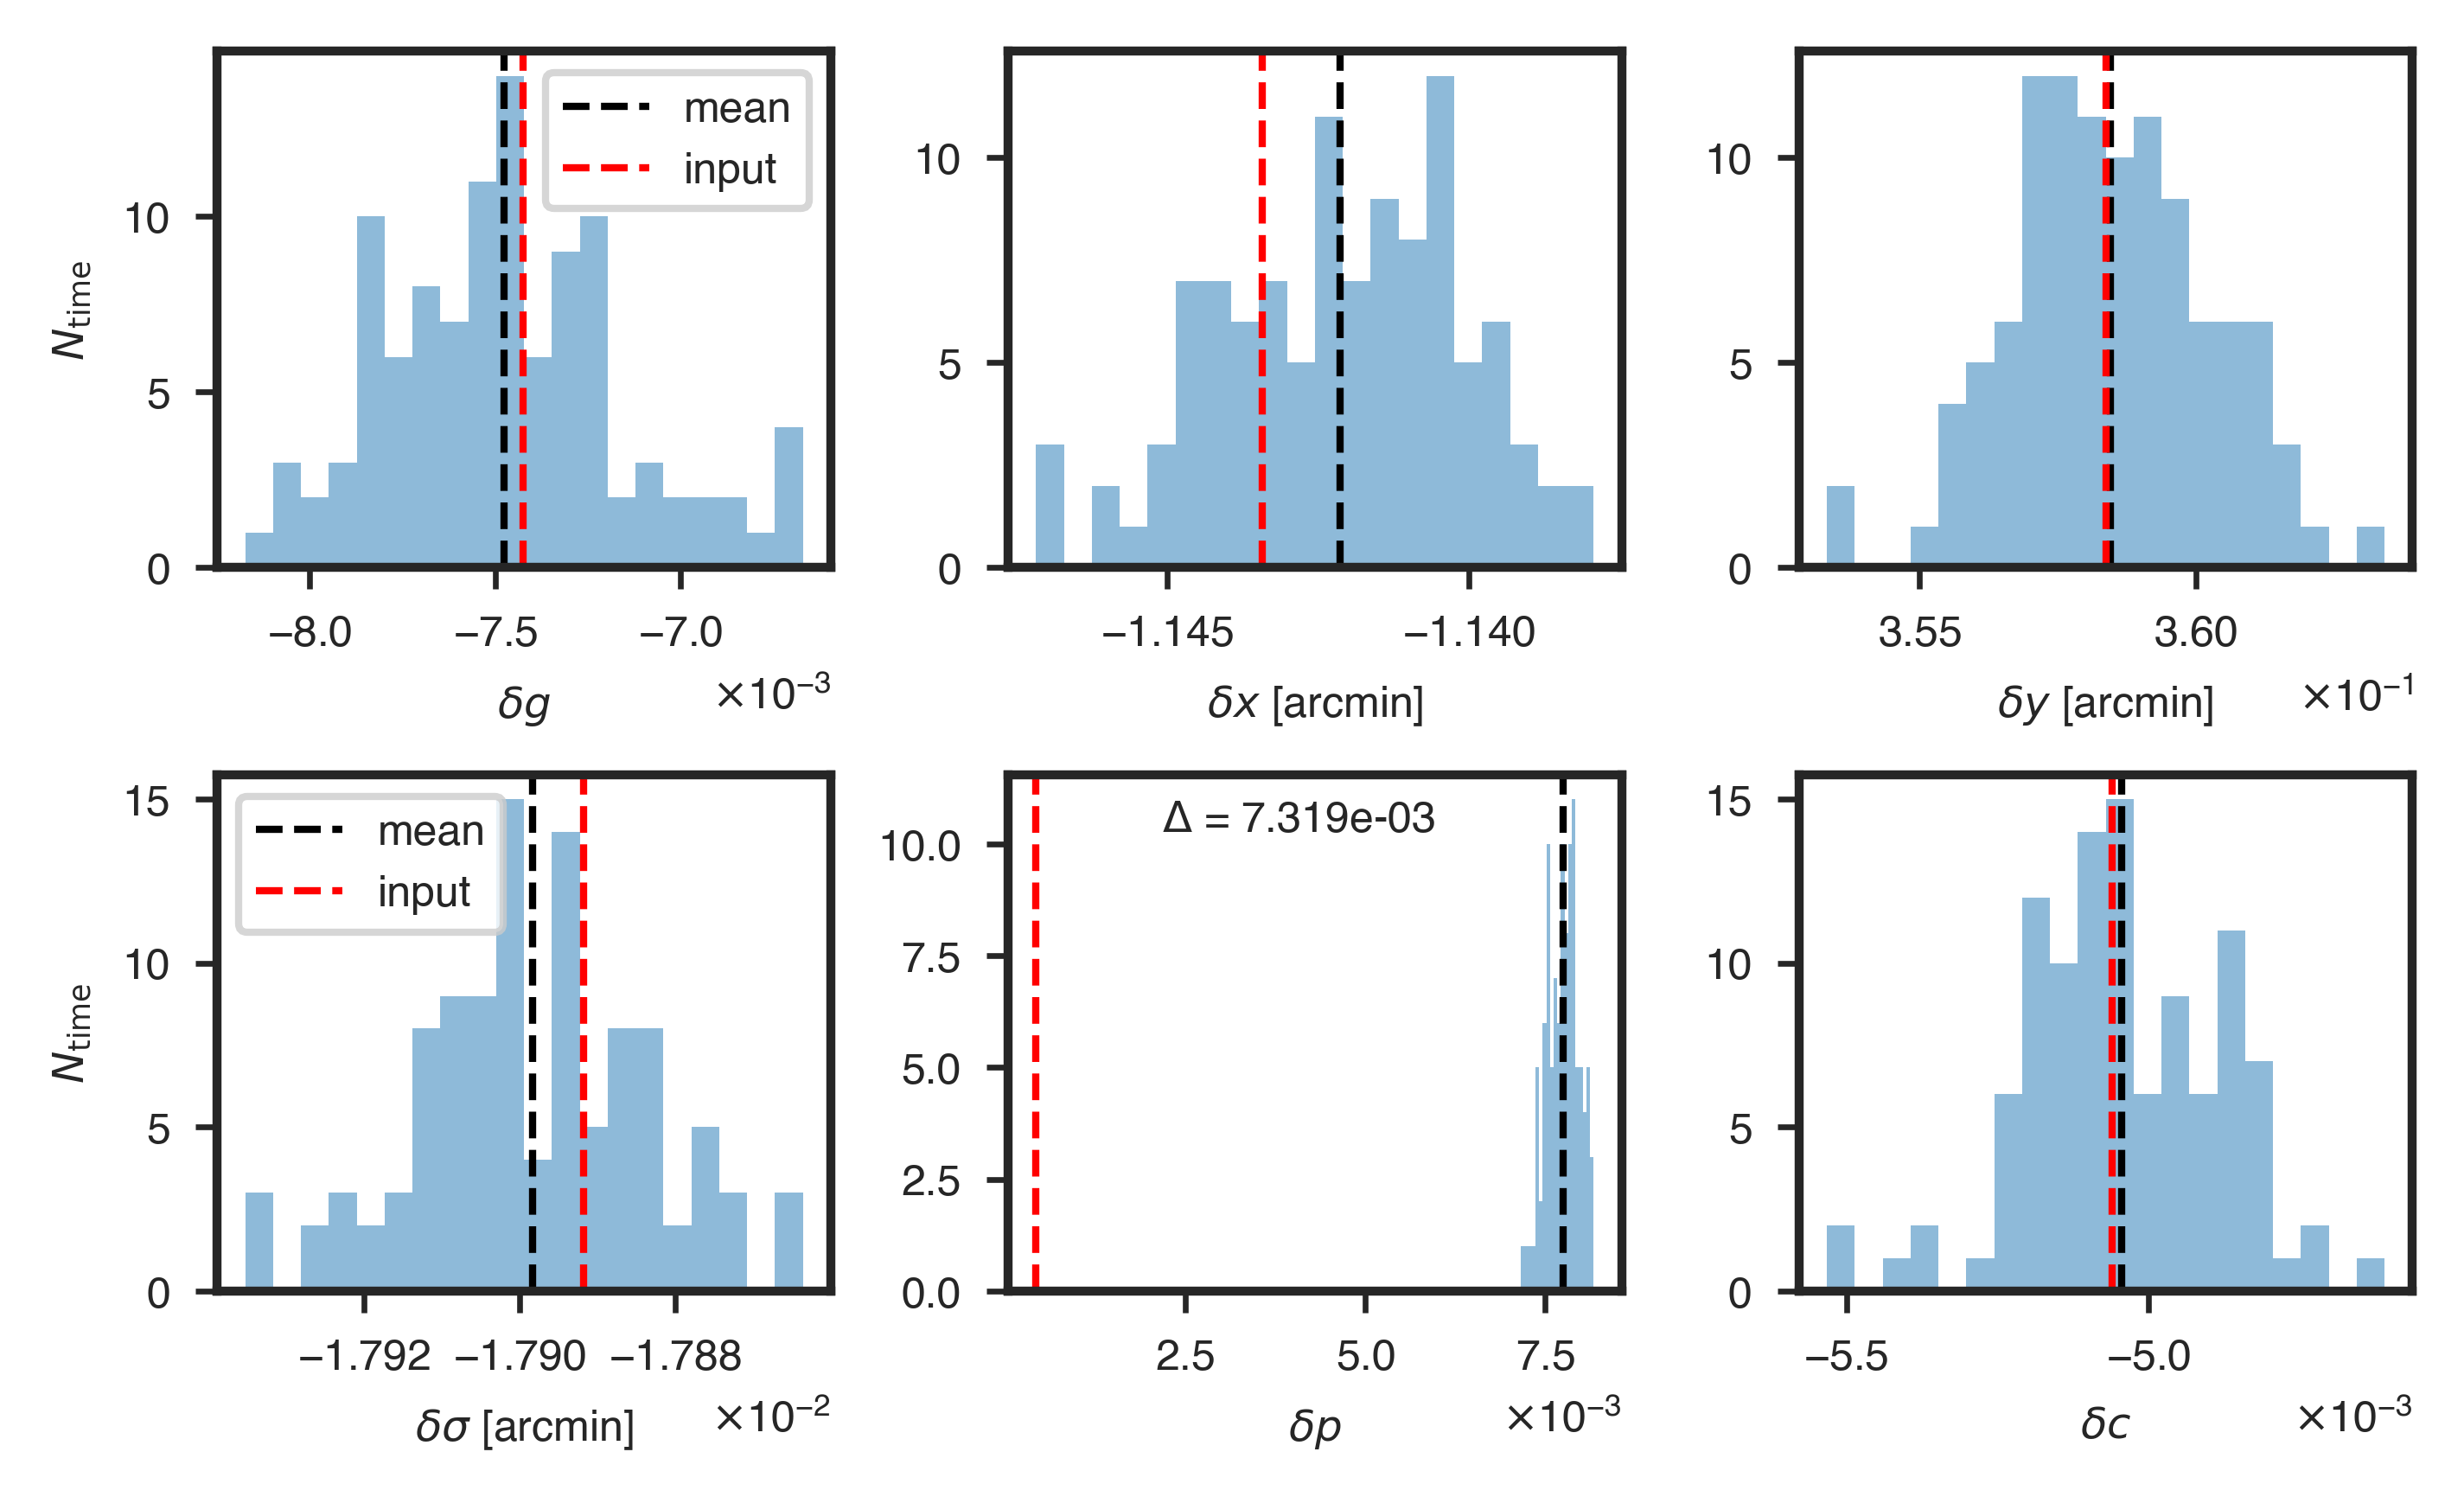

In [318]:
nu = 150
dg0 = np.loadtxt(root+'beamsys/dg_%dG.txt'%(nu)).T[2][isim]
ds0 = np.loadtxt(root+'beamsys/dsigma_%dG.txt'%(nu)).T[2][isim]
dx0_fp = np.loadtxt(root+'beamsys/dx_%dG.txt'%(nu)).T[2][isim]
dy0_fp = np.loadtxt(root+'beamsys/dy_%dG.txt'%(nu)).T[2][isim]
de0_mod = np.loadtxt(root+'beamsys/de_conti_%dG.txt'%(nu)).T[2][isim]
de0_ori = np.loadtxt(root+'beamsys/de_orient_%dG.txt'%(nu)).T[2][isim]

# pointing difference
dx0_lcl = np.cos(_dblang[isim]) * dx0_fp + np.sin(_dblang[isim]) * dy0_fp
dy0_lcl = -np.sin(_dblang[isim]) * dx0_fp + np.cos(_dblang[isim]) * dy0_fp

# dsigma to dfwhm

# eccentricity (temporary solution of jjin)
# Here, base on the defination of de_ori by jjin, de_ori represents
# the angle between the major axis of the beam difference map, at
# linear order the beam difference map can be treated as an indivi-
# dual ecliptic beam map, and the favour orientation of UP detector.
dp0 = de0_mod * np.cos(_dblang[isim] + 2.*de0_ori)
dc0 = de0_mod * np.sin(_dblang[isim] + 2.*de0_ori)

# print("first sim & detector pair @ "+str(nu)+'G')
# print("dg dsigma[deg] dx[deg] dy[deg] dp dc")
# print(dg0, ds0, dx0_lcl, dy0_lcl, dp0, dc0)

def plot_pdf(ax, data, real_val, xlabel, start=False, bias=False):
    '''
    plot the probability density function
    '''
    # pdf, bins = np.histogram(data, bins=20, density=True)
    # bin_ctr = (bins[:-1] + bins[1:]) / 2.
    # print(bins, bin_ctr)
    # ax.plot(bin_ctr, pdf, ls, lw=1., alpha=1., label=label)
    ax.hist(data, bins=20, alpha=0.5)
    ax.ticklabel_format(style='sci', scilimits=(0,0), axis='x', useMathText=True)
    lw = 1.
    ls = '--'
    if start:
        ax.axvline(np.mean(data), ls=ls, lw=lw, color='k', label='mean')
        ax.axvline(real_val, ls=ls, lw=lw, color='r', label='input')
        ax.legend(loc='best', frameon=True)
        ax.set_ylabel(r'$N_{\rm time}$')
    else:
        ax.axvline(np.mean(data), ls=ls, lw=lw, color='k')
        ax.axvline(real_val, ls=ls, lw=lw, color='r')
    if bias:
        bias = np.mean(data) - real_val
        ax.text(0.25, 0.95, r'$\Delta$'+' = {:.3e}'.format(bias), ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel(xlabel)
    ax.tick_params(size=3)

idet = 1
fig, axs = plt.subplots(2, 3, tight_layout=True, figsize=(4.8, 2.9), dpi=600)
plt.style.use('seaborn-v0_8-ticks')
plt.rc('font', family='sans-serif', size=6)
plt.rcParams['font.sans-serif'] = 'Helvetica'
plot_pdf(axs[0,0], dg[:,idet], dg0, r'$\delta g$', start=True)
plot_pdf(axs[0,1], dx[:,idet] * 60., dx0_lcl * 60., r'$\delta x$ [arcmin]')
plot_pdf(axs[0,2], dy[:,idet] * 60., dy0_lcl * 60., r'$\delta y$ [arcmin]')
plot_pdf(axs[1,0], ds[:,idet] * 60., ds0 * 60., r'$\delta\sigma$ [arcmin]', start=True)
plot_pdf(axs[1,1], dp[:,idet], dp0, r'$\delta p$', bias=True)
plot_pdf(axs[1,2], dc[:,idet], dc0, r'$\delta c$')
# plt.show()
plt.savefig('/home/doujzh/Documents/djzfiles/plots_paper/depr_params.png',bbox_inches='tight',pad_inches=0.1)

median, max =  4.655751701959529e-05 0.004454612532279206
Number of weird  8
median, max =  0.0005850071179392714 0.0122945147970107
Number of weird  20
median, max =  0.000661843661772972 0.013259677390990848
Number of weird  15
median, max =  5.86402651538804e-06 0.0013160558282437895
Number of weird  42
median, max =  8.583647666037496e-05 0.0004859016525404344
Number of weird  0
median, max =  3.447035517391761e-05 0.0002892981528420553
Number of weird  0


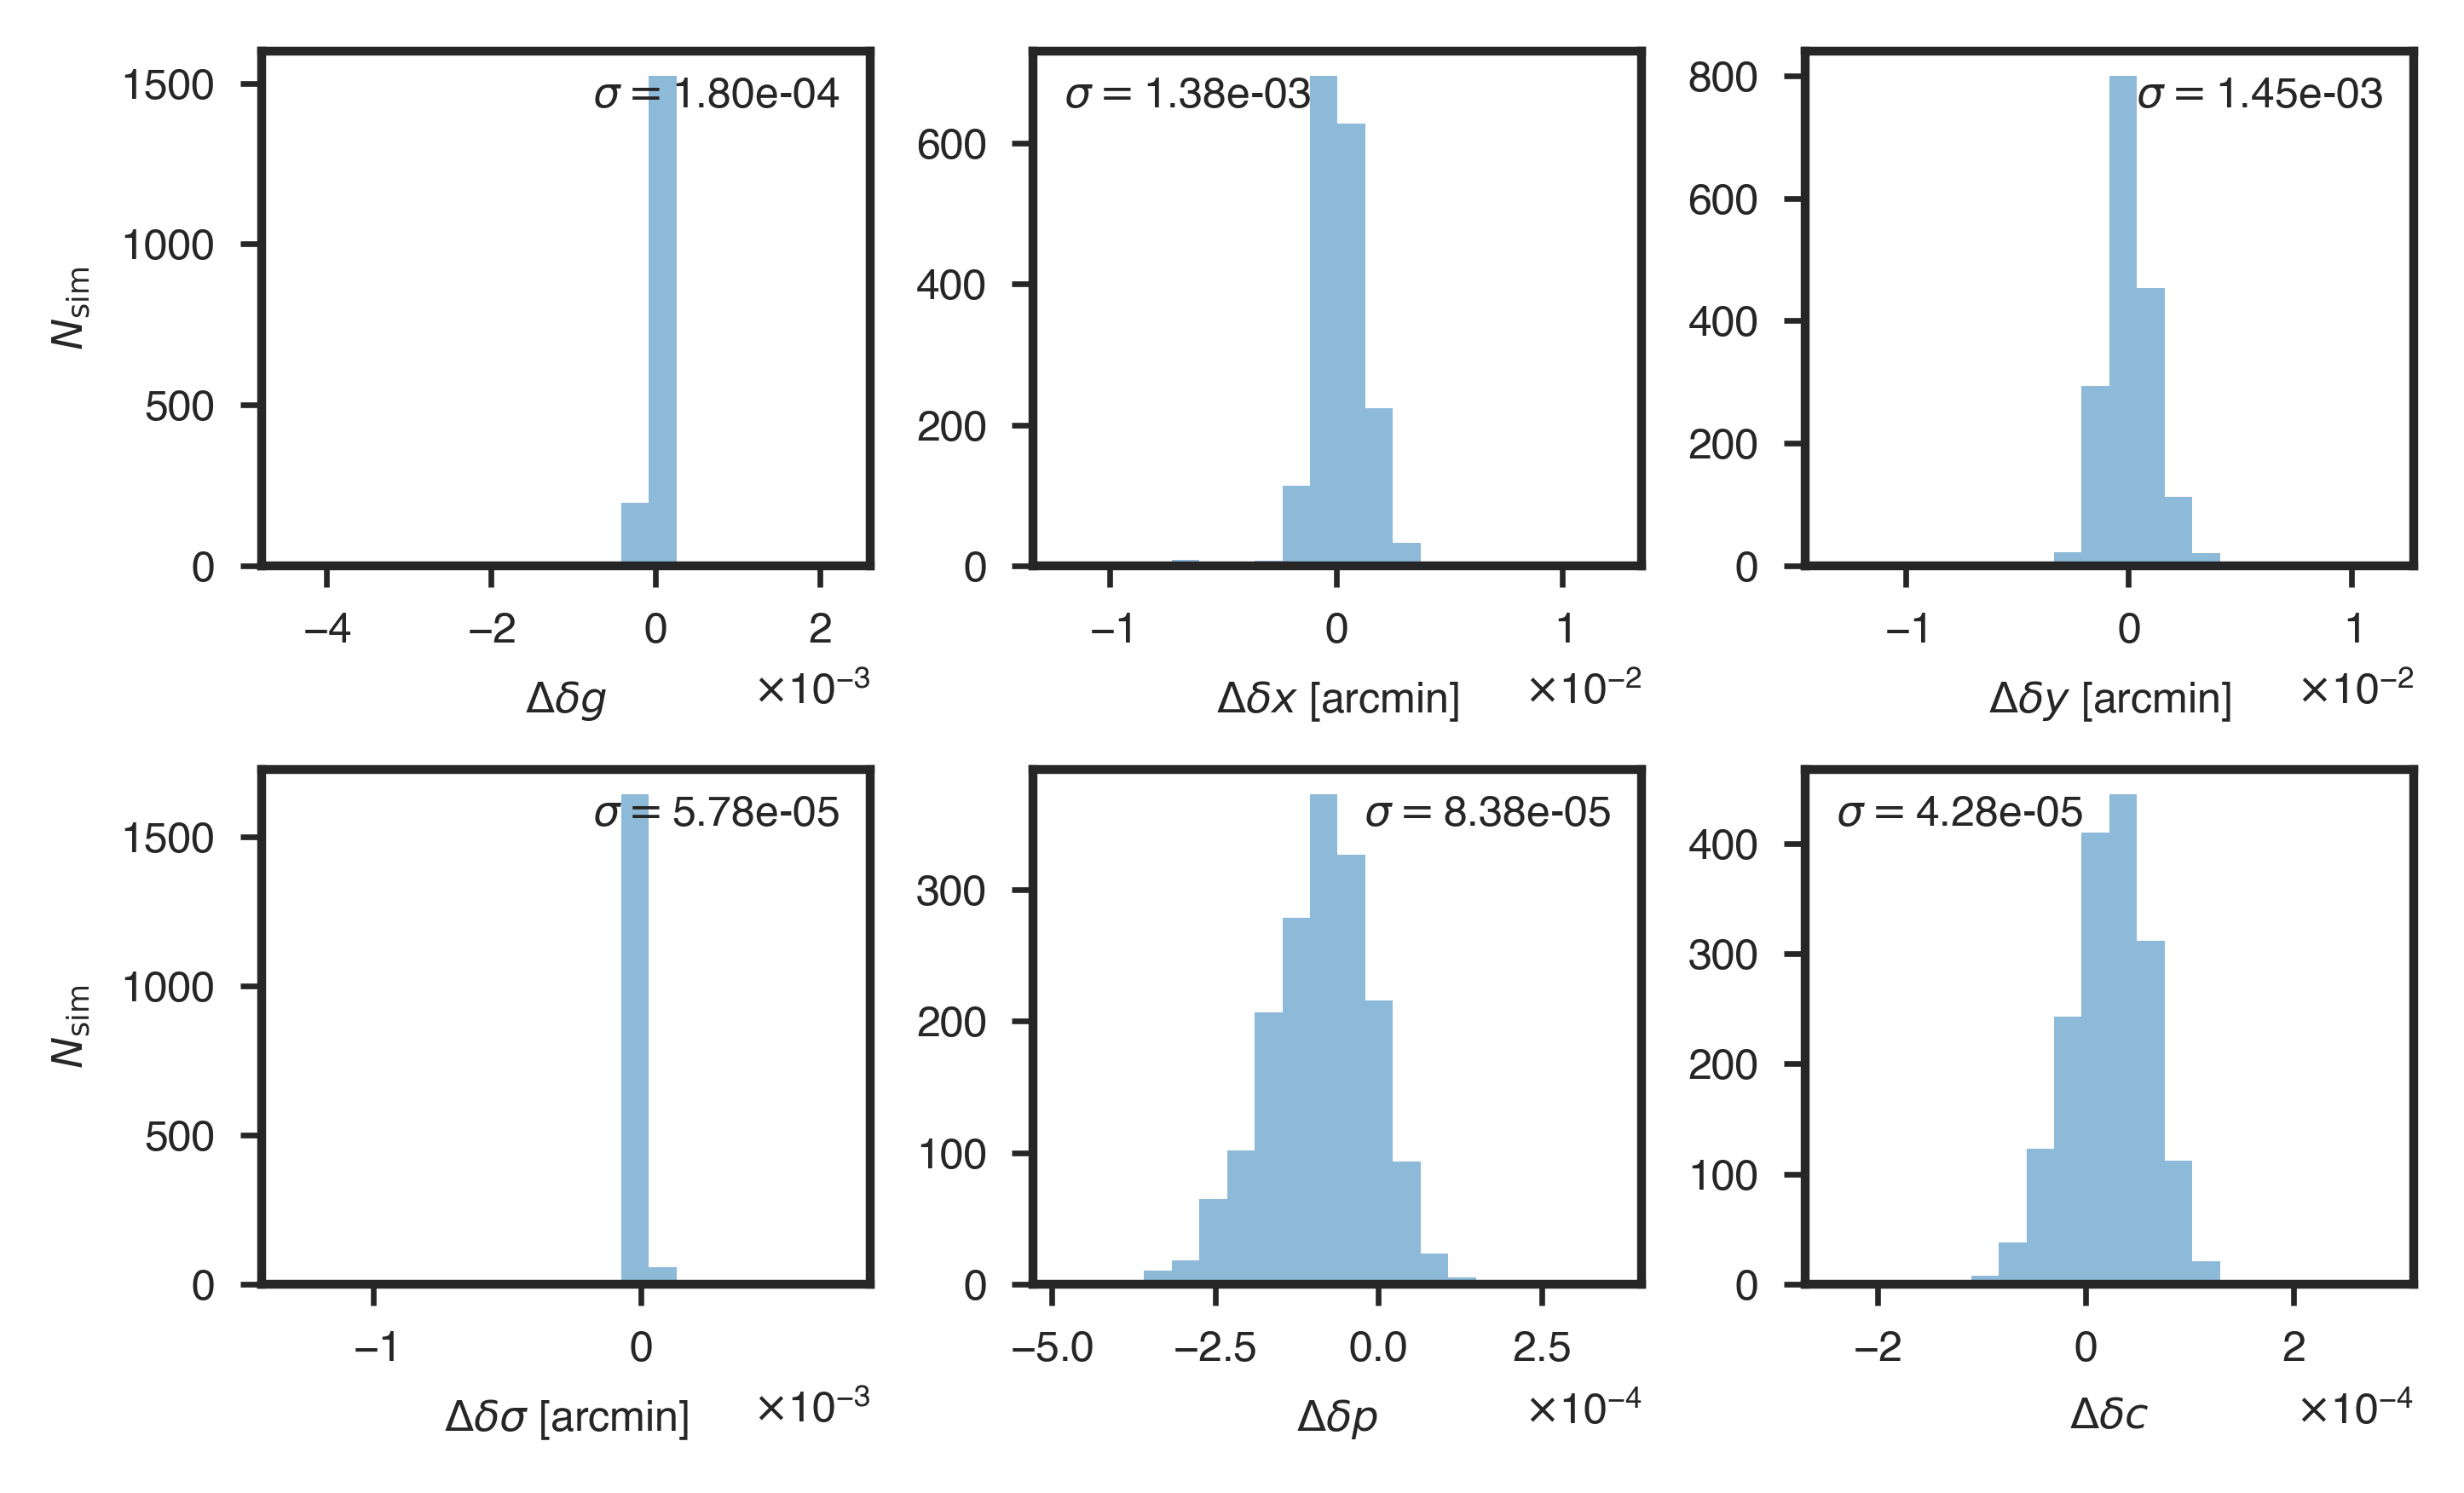

In [307]:
nu = 150
dg0 = np.loadtxt(root+'beamsys/dg_%dG.txt'%(nu)).T[2]
ds0 = np.loadtxt(root+'beamsys/dsigma_%dG.txt'%(nu)).T[2]
dx0_fp = np.loadtxt(root+'beamsys/dx_%dG.txt'%(nu)).T[2]
dy0_fp = np.loadtxt(root+'beamsys/dy_%dG.txt'%(nu)).T[2]
de0_mod = np.loadtxt(root+'beamsys/de_conti_%dG.txt'%(nu)).T[2]
de0_ori = np.loadtxt(root+'beamsys/de_orient_%dG.txt'%(nu)).T[2]

# pointing difference
dx0_lcl = np.cos(_dblang) * dx0_fp + np.sin(_dblang) * dy0_fp
dy0_lcl = -np.sin(_dblang) * dx0_fp + np.cos(_dblang) * dy0_fp

# dsigma to dfwhm

# eccentricity (temporary solution of jjin)
# Here, base on the defination of de_ori by jjin, de_ori represents
# the angle between the major axis of the beam difference map, at
# linear order the beam difference map can be treated as an indivi-
# dual ecliptic beam map, and the favour orientation of UP detector.
dp0 = de0_mod * np.cos(_dblang + 2.*de0_ori)
dc0 = de0_mod * np.sin(_dblang + 2.*de0_ori)

# print("first sim & detector pair @ "+str(nu)+'G')
# print("dg dsigma[deg] dx[deg] dy[deg] dp dc")
# print(dg0, ds0, dx0_lcl, dy0_lcl, dp0, dc0)
dlt_dg = np.mean(dg, axis=0) - dg0
dlt_ds = np.mean(ds, axis=0) - ds0
dlt_dx = np.mean(dx, axis=0) - dx0_lcl
dlt_dy = np.mean(dy, axis=0) - dy0_lcl
dlt_dp = np.mean(dp, axis=0) - dp0 - 7.3e-3
dlt_dc = np.mean(dc, axis=0) - dc0
# print(dlt_dg, dlt_dx * 60, dlt_dy * 60, dlt_ds * 60, dlt_dp, dlt_dc)

def plot_pdf(ax, data, xpos, xlabel, start=False):
    '''
    plot the probability density function
    '''
    # data[np.abs(data)>10. * np.median(np.abs(data))] = 0.
    # pdf, bins = np.histogram(data, bins=20, density=True)
    # bin_ctr = (bins[:-1] + bins[1:]) / 2.
    # print(bins, bin_ctr)
    # ax.plot(bin_ctr, pdf, ls, lw=1., alpha=1., label=label)
    ax.hist(data, bins=20, alpha=0.5)
    ax.ticklabel_format(style='sci', scilimits=(0,0), axis='x', useMathText=True)
    lw = 1.
    ls = '--'
    if start:
    #     ax.axvline(np.mean(data), ls=ls, lw=lw, color='k', label='mean')
    #     ax.axvline(real_val, ls=ls, lw=lw, color='r', label='input')
    #     ax.legend(loc='best', frameon=True)
        ax.set_ylabel(r'$N_{\rm sim}$')
    # else:
    #     ax.axvline(np.mean(data), ls=ls, lw=lw, color='k')
    #     ax.axvline(real_val, ls=ls, lw=lw, color='r')
    ax.set_xlabel(xlabel)
    ax.tick_params(size=3)
    mean = np.mean(data)
    std = np.std(data)
    print("median, max = ", np.median(np.abs(data)), np.max(np.abs(data)))
    print("Number of weird ", np.sum(np.abs(data)>10. * np.median(np.abs(data))))
    # print("mean, sigma = ", mean, std)
    if xpos == 0:
        ax.text(0.05, 0.95, r'$\sigma = $'+"{:.2e}".format(std), ha='left', va='top', transform=ax.transAxes)
    elif xpos == 1:
        ax.text(0.95, 0.95, r'$\sigma = $'+"{:.2e}".format(std), ha='right', va='top', transform=ax.transAxes)

fig, axs = plt.subplots(2, 3, tight_layout=True, figsize=(4.8, 2.9), dpi=600)
plt.style.use('seaborn-v0_8-ticks')
plt.rc('font', family='sans-serif', size=6)
plt.rcParams['font.sans-serif'] = 'Helvetica'
ndec = np.arange(1728)
plot_pdf(axs[0,0], dlt_dg[ndec], 1, r'$\Delta\delta g$', start=True)
plot_pdf(axs[0,1], dlt_dx[ndec] * 60, 0, r'$\Delta\delta x$ [arcmin]')
plot_pdf(axs[0,2], dlt_dy[ndec] * 60, 1, r'$\Delta\delta y$ [arcmin]')
plot_pdf(axs[1,0], dlt_ds[ndec] * 60, 1, r'$\Delta\delta\sigma$ [arcmin]', start=True)
plot_pdf(axs[1,1], dlt_dp[ndec], 1, r'$\Delta\delta p$')
plot_pdf(axs[1,2], dlt_dc[ndec], 0, r'$\Delta\delta c$')
plt.show()

0.007210836786586418


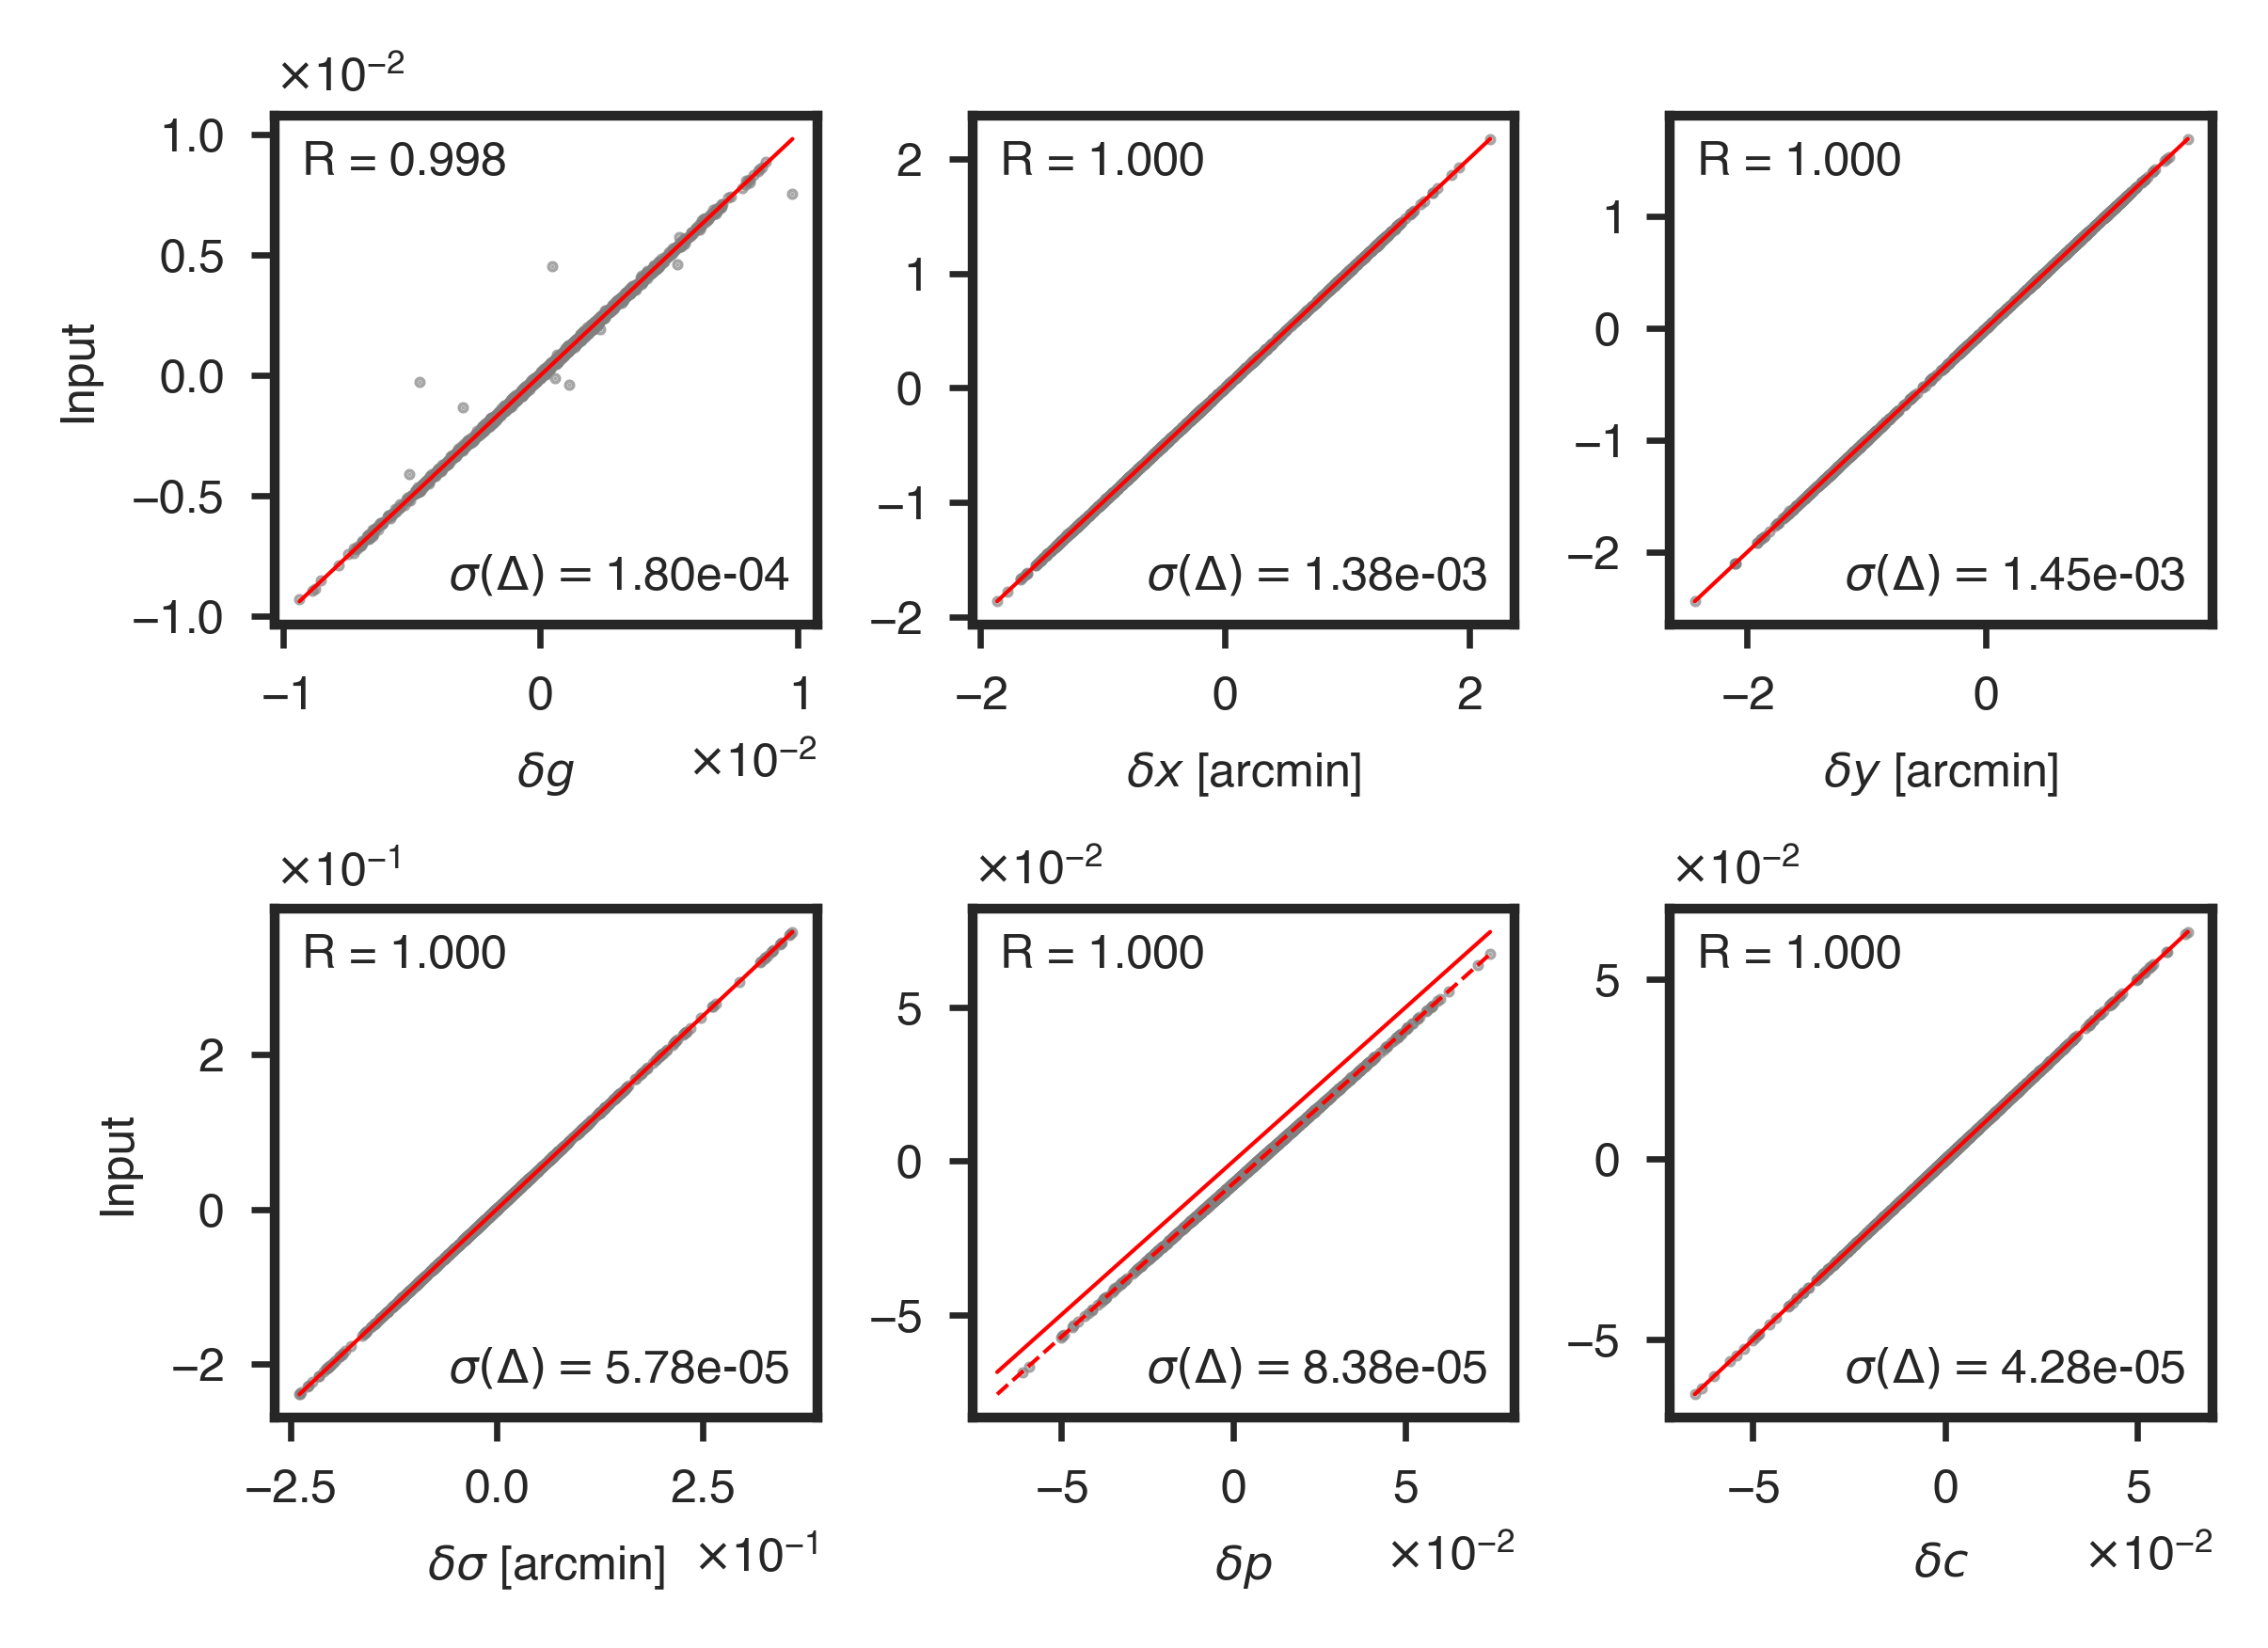

In [321]:
nu = 150
dg0 = np.loadtxt(root+'beamsys/dg_%dG.txt'%(nu)).T[2]
ds0 = np.loadtxt(root+'beamsys/dsigma_%dG.txt'%(nu)).T[2]
dx0_fp = np.loadtxt(root+'beamsys/dx_%dG.txt'%(nu)).T[2]
dy0_fp = np.loadtxt(root+'beamsys/dy_%dG.txt'%(nu)).T[2]
de0_mod = np.loadtxt(root+'beamsys/de_conti_%dG.txt'%(nu)).T[2]
de0_ori = np.loadtxt(root+'beamsys/de_orient_%dG.txt'%(nu)).T[2]

# pointing difference
dx0_lcl = np.cos(_dblang) * dx0_fp + np.sin(_dblang) * dy0_fp
dy0_lcl = -np.sin(_dblang) * dx0_fp + np.cos(_dblang) * dy0_fp
dx0 = dx0_lcl
dy0 = dy0_lcl
# dsigma to dfwhm

# eccentricity (temporary solution of jjin)
# Here, base on the defination of de_ori by jjin, de_ori represents
# the angle between the major axis of the beam difference map, at
# linear order the beam difference map can be treated as an indivi-
# dual ecliptic beam map, and the favour orientation of UP detector.
dp0 = de0_mod * np.cos(_dblang + 2.*de0_ori)
dc0 = de0_mod * np.sin(_dblang + 2.*de0_ori)

# print("first sim & detector pair @ "+str(nu)+'G')
# print("dg dsigma[deg] dx[deg] dy[deg] dp dc")
# print(dg0, ds0, dx0_lcl, dy0_lcl, dp0, dc0)
dg_mean = np.mean(dg, axis=0)
ds_mean = np.mean(ds, axis=0)
dx_mean = np.mean(dx, axis=0)
dy_mean = np.mean(dy, axis=0)
dp_mean = np.mean(dp, axis=0)
dc_mean = np.mean(dc, axis=0)
# print(dlt_dg, dlt_dx * 60, dlt_dy * 60, dlt_ds * 60, dlt_dp, dlt_dc)
print(np.mean(dp_mean-dp0))
def plot_pdf(ax, data0, data1, xlabel, bias=None, start=False):
    '''
    plot the probability density function
    '''
    # data[np.abs(data)>10. * np.median(np.abs(data))] = 0.
    xrange = np.linspace(np.minimum(min(data0), min(data1)), np.maximum(max(data0), max(data1)), 100)
    ax.plot(xrange, xrange, 'r-', lw=0.5)
    if bias:
        ax.plot(xrange, xrange-bias, 'r--', lw=0.5)
    ax.scatter(data0, data1, s=0.2, c='grey', alpha=0.7)
    ax.ticklabel_format(style='sci', scilimits=(0,0), axis='both', useMathText=True)
    ax.set_xlabel(xlabel)
    ax.tick_params(size=3)
    corr = np.corrcoef(data0, data1)[0,1]
    ax.text(0.05, 0.95, 'R = {:.3f}'.format(corr), ha='left', va='top', transform=ax.transAxes)
    std = np.std(data0-data1)
    ax.text(0.95, 0.05, r'$\sigma(\Delta) = $'+"{:.2e}".format(std), ha='right', va='bottom', transform=ax.transAxes)
    if start:
        ax.set_ylabel('Input')

fig, axs = plt.subplots(2, 3, tight_layout=True, figsize=(4., 2.9), dpi=600)
plt.style.use('seaborn-v0_8-ticks')
plt.rc('font', family='sans-serif', size=6)
plt.rcParams['font.sans-serif'] = 'Helvetica'
ndec = np.arange(0,1728)
plot_pdf(axs[0,0], dg_mean[ndec], dg0[ndec], r'$\delta g$', start=True)
plot_pdf(axs[0,1], dx_mean[ndec] * 60, dx0[ndec] * 60, r'$\delta x$ [arcmin]')
plot_pdf(axs[0,2], dy_mean[ndec] * 60, dy0[ndec] * 60, r'$\delta y$ [arcmin]')
plot_pdf(axs[1,0], ds_mean[ndec] * 60, ds0[ndec] * 60, r'$\delta\sigma$ [arcmin]', start=True)
plot_pdf(axs[1,1], dp_mean[ndec], dp0[ndec], r'$\delta p$', bias=7.2108e-3)
plot_pdf(axs[1,2], dc_mean[ndec], dc0[ndec], r'$\delta c$')
# plt.show()
plt.savefig('/home/doujzh/Documents/djzfiles/plots_paper/depr_res.png',bbox_inches='tight',pad_inches=0.1)
